In [38]:
import pandas as pd
import numpy as np
import torch as th
import paradime
import paradime.dr
import paradime.loss
import paradime.routines
import paradime.utils
from matplotlib import pyplot as plt
from sklearn import datasets
import torchvision
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

In [39]:
mnist = torchvision.datasets.MNIST(
    '../data',
    train=True,
    download=True,
)
mnist_data = mnist.data.reshape(-1, 28*28) / 255.
num_items = 5000

mnist_subset = mnist_data[:num_items]
target_subset = mnist.targets[:num_items]

In [40]:
class twoNAMHybrid(th.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, output_dim=2, num_layers=1):
        super(twoNAMHybrid, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.submodules = th.nn.ModuleList()
        self.alpha = th.nn.Parameter(th.tensor(1.0))

        # Create the submodules for each input feature
        for i in range(input_dim):
            submodule = th.nn.Sequential()
            # Add layers to the submodule
            for l in range(num_layers):
                if l == 0:
                    submodule.add_module(f"linear_{l}", th.nn.Linear(1, hidden_dim))
                else:
                    submodule.add_module(f"linear_{l}", th.nn.Linear(hidden_dim, hidden_dim))
                submodule.add_module(f"ELU_{l}", th.nn.ELU())
                submodule.add_module(f"dropout_{l}", th.nn.Dropout(0.5))

            # Add the output layer
            submodule.add_module(f"linear_{num_layers}", th.nn.Linear(hidden_dim, hidden_dim))
            self.submodules.append(submodule)

        # Add the final layer
        self.emb_layer = th.nn.Linear(input_dim * hidden_dim, output_dim)
        self.class_layer = th.nn.Linear(input_dim * hidden_dim, num_classes)

    def common_forward(self, x):
        # Initialize a list to store the outputs of submodules
        output = []
        for i in range(self.input_dim):
            # Compute the output of the i-th submodule and append it to the list
            output.append(self.submodules[i](x[:, i].unsqueeze(1)).squeeze())
        # Concatenate the outputs along the first dimension
        output = th.cat(output, dim=1)
        return output

    def embed(self, x):
        x = self.common_forward(x)
        x = self.emb_layer(x)
        return x

    def classify(self, x):
        x = self.common_forward(x)
        x = self.class_layer(x)
        return x

In [41]:
tsne = paradime.routines.ParametricTSNE(in_dim=28*28)
global_rel = tsne.global_relations
batch_rel = tsne.batch_relations

embeddings = []
sil_scores = []
learning_rates = [0.001, 0.01, 0.1]
num_epochs = [10, 20, 30]
hidden_dims = [50, 100, 150]

for lr in learning_rates:
    for epoch in num_epochs:
        for h_dim in hidden_dims:
            paradime.utils.logging.log(f"Learning rate: {lr}, Epochs: {epoch}, Hidden dim: {h_dim}")

            tsne_main = paradime.dr.TrainingPhase(
                name="embedding",
                loss_keys=["embedding"],
                batch_size=500,
                epochs=epoch,
                learning_rate=lr,
                report_interval=2,
            )
            
            hybrid_tsne = paradime.dr.ParametricDR(
                model=twoNAMHybrid(
                    input_dim=28 * 28, hidden_dim=h_dim, num_classes=10, output_dim=2,
                ),
                global_relations=global_rel,
                batch_relations=batch_rel,
                losses=losses,
                use_cuda=True,
                verbose=True,
            )
            hybrid_tsne.add_training_phase(tsne_main)
            
            hybrid_tsne.train({
                "main": mnist_subset,
                "labels": target_subset,
            })

            emb = hybrid_tsne.apply(mnist_subset, "embed")
            embeddings.append(emb)

            # Compute silhouette score
            sil_score = silhouette_score(emb.cpu().detach().numpy(), target_subset.numpy())
            sil_scores.append(sil_score)

2023-06-24 17:56:59,326: Learning rate: 0.001, Epochs: 10, Hidden dim: 50
2023-06-24 17:56:59,760: Initializing training dataset.
2023-06-24 17:56:59,761: Computing global relations 'rel'.
2023-06-24 17:56:59,762: Indexing nearest neighbors.
2023-06-24 17:57:00,867: Calculating probabilities.
2023-06-24 17:57:01,145: Beginning training phase 'embedding'.
2023-06-24 17:57:05,153: Loss after epoch 0: 0.08809610921889544
2023-06-24 17:57:12,508: Loss after epoch 2: 0.0746237738057971
2023-06-24 17:57:20,105: Loss after epoch 4: 0.07382796797901392
2023-06-24 17:57:27,670: Loss after epoch 6: 0.0738045759499073
2023-06-24 17:57:34,997: Loss after epoch 8: 0.07359819859266281
2023-06-24 17:57:39,315: Learning rate: 0.001, Epochs: 10, Hidden dim: 100
2023-06-24 17:57:39,672: Initializing training dataset.
2023-06-24 17:57:39,672: Computing global relations 'rel'.
2023-06-24 17:57:39,673: Indexing nearest neighbors.
2023-06-24 17:57:40,725: Calculating probabilities.
2023-06-24 17:57:41,003: 

2023-06-24 18:07:30,407: Loss after epoch 4: 0.07461152598261833
2023-06-24 18:07:38,567: Loss after epoch 6: 0.07390680303797126
2023-06-24 18:07:46,510: Loss after epoch 8: 0.07582333544269204
2023-06-24 18:07:54,670: Loss after epoch 10: 0.07531271828338504
2023-06-24 18:08:02,828: Loss after epoch 12: 0.07620003400370479
2023-06-24 18:08:10,768: Loss after epoch 14: 0.0755665423348546
2023-06-24 18:08:18,877: Loss after epoch 16: 0.07605342846363783
2023-06-24 18:08:26,995: Loss after epoch 18: 0.07760615181177855
2023-06-24 18:08:34,891: Loss after epoch 20: 0.07746800500899553
2023-06-24 18:08:43,013: Loss after epoch 22: 0.07814203854650259
2023-06-24 18:08:51,206: Loss after epoch 24: 0.07777907280251384
2023-06-24 18:08:59,158: Loss after epoch 26: 0.0783991040661931
2023-06-24 18:09:07,280: Loss after epoch 28: 0.07965418230742216
2023-06-24 18:09:11,693: Learning rate: 0.01, Epochs: 10, Hidden dim: 50
2023-06-24 18:09:12,234: Initializing training dataset.
2023-06-24 18:09:1

2023-06-24 18:18:37,413: Loss after epoch 18: 0.11506918631494045
2023-06-24 18:18:45,402: Loss after epoch 20: 0.11501129437237978
2023-06-24 18:18:53,617: Loss after epoch 22: 0.11529642157256603
2023-06-24 18:19:01,610: Loss after epoch 24: 0.11276433430612087
2023-06-24 18:19:09,786: Loss after epoch 26: 0.11310558207333088
2023-06-24 18:19:17,997: Loss after epoch 28: 0.11093600932508707
2023-06-24 18:19:22,407: Learning rate: 0.01, Epochs: 30, Hidden dim: 150
2023-06-24 18:19:23,042: Initializing training dataset.
2023-06-24 18:19:23,043: Computing global relations 'rel'.
2023-06-24 18:19:23,043: Indexing nearest neighbors.
2023-06-24 18:19:24,202: Calculating probabilities.
2023-06-24 18:19:24,481: Beginning training phase 'embedding'.
2023-06-24 18:19:28,526: Loss after epoch 0: 0.09155553858727217
2023-06-24 18:19:36,467: Loss after epoch 2: 0.09904586244374514
2023-06-24 18:19:44,627: Loss after epoch 4: 0.10513255558907986
2023-06-24 18:19:52,881: Loss after epoch 6: 0.10611

2023-06-24 18:29:34,030: Initializing training dataset.
2023-06-24 18:29:34,030: Computing global relations 'rel'.
2023-06-24 18:29:34,031: Indexing nearest neighbors.
2023-06-24 18:29:35,247: Calculating probabilities.
2023-06-24 18:29:35,525: Beginning training phase 'embedding'.
2023-06-24 18:29:39,919: Loss after epoch 0: 0.11280142050236464
2023-06-24 18:29:47,923: Loss after epoch 2: 0.11799596436321735
2023-06-24 18:29:56,175: Loss after epoch 4: 0.11817224882543087
2023-06-24 18:30:04,474: Loss after epoch 6: 0.1150458175688982
2023-06-24 18:30:12,400: Loss after epoch 8: 0.1167939081788063
2023-06-24 18:30:20,568: Loss after epoch 10: 0.11508456710726023
2023-06-24 18:30:28,755: Loss after epoch 12: 0.11471422575414181
2023-06-24 18:30:36,716: Loss after epoch 14: 0.11269619688391685
2023-06-24 18:30:44,877: Loss after epoch 16: 0.11125247925519943
2023-06-24 18:30:53,016: Loss after epoch 18: 0.11233159340918064
2023-06-24 18:31:00,942: Loss after epoch 20: 0.1179178319871425

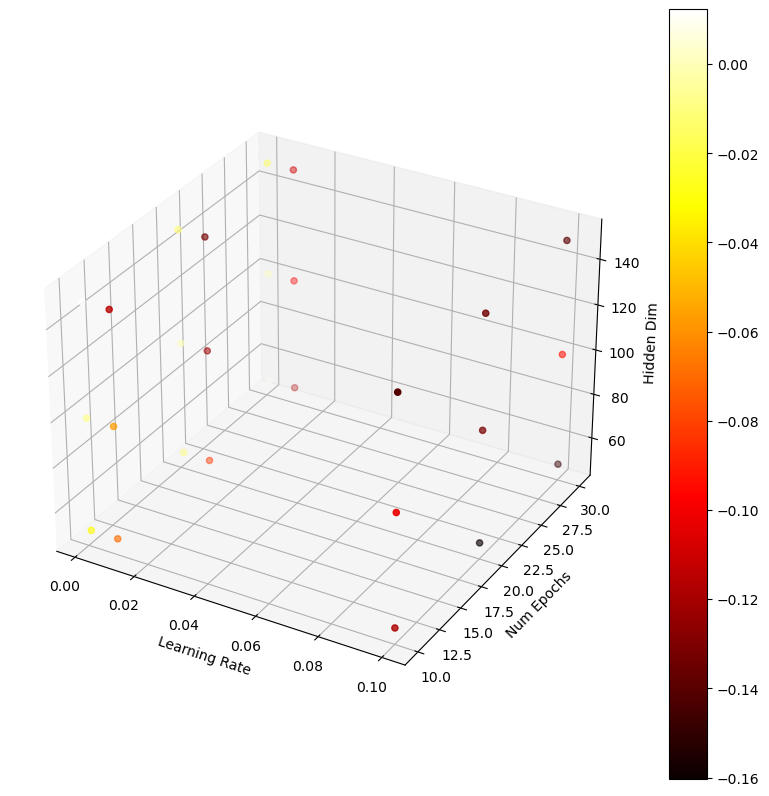

In [42]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x = np.repeat(learning_rates, len(num_epochs)*len(hidden_dims))
y = np.tile(np.repeat(num_epochs, len(hidden_dims)), len(learning_rates))
z = np.tile(hidden_dims, len(learning_rates)*len(num_epochs))
c = sil_scores

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Num Epochs')
ax.set_zlabel('Hidden Dim')
plt.show()

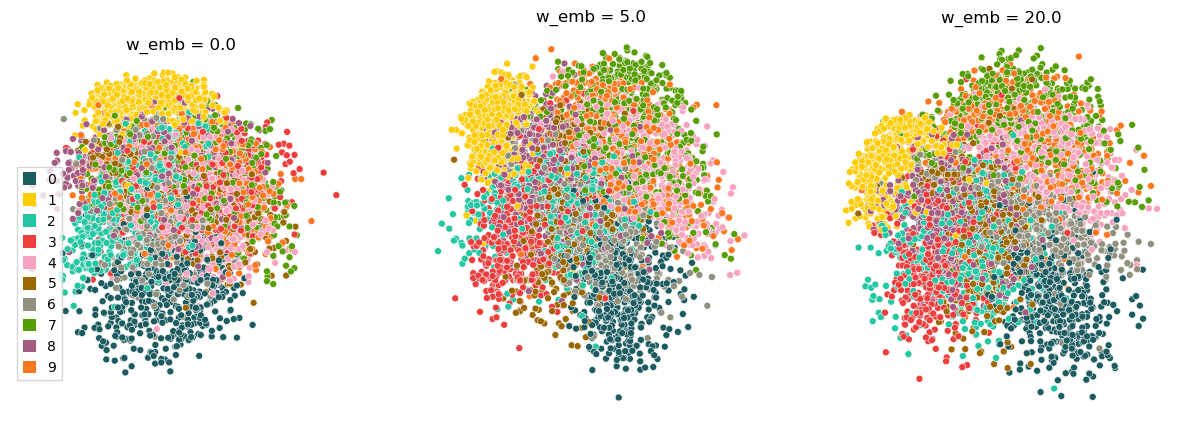

In [43]:
# Create a figure
fig = plt.figure(figsize=(15, 5))

# Create a scatter plot for each embedding
for i, (emb, w) in enumerate(zip(embeddings, weights)):
    ax = fig.add_subplot(1, 3, i + 1)
    
    # Use Paradime's scatterplot utility to plot the embedding with class labels as colors
    paradime.utils.plotting.scatterplot(
        emb,
        labels=target_subset,
        ax=ax,
        legend=(i == 0),
        legend_options={"loc": 3},
    )
    ax.set_title(f"w_emb = {w}")